<a href="https://colab.research.google.com/github/ggrotewold/FluShot/blob/main/FluShot_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature-cleansing
prepare features for training






In [1]:
# load features from google.drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
training_features = pd.read_csv('/content/drive/My Drive/FluShotData/training_set_features.csv')
training_features = training_features.set_index('respondent_id')
training_labels = pd.read_csv('/content/drive/My Drive/FluShotData/training_set_labels.csv')
training_labels = training_labels.set_index('respondent_id')
training_features.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [3]:
category_labels = ['h1n1_concern','h1n1_knowledge','doctor_recc_h1n1','doctor_recc_seasonal',
                   'chronic_med_condition','health_worker','health_insurance','opinion_h1n1_vacc_effective',
                   'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective',
                   'opinion_seas_risk','opinion_seas_sick_from_vacc','age_group','race','employment_status']
numeric_labels = ['household_children']

training_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
# convert objects in to label-encoded values
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

class SetCatType(TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype('category')

class FillMissingCatValues(TransformerMixin):
  def fit(self, X):
    return self
  def transform(self, X):
    assert isinstance(X, pd.DataFrame)
    X = X.fillna('missing')
    return X

class DataFrameEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, drop_first=False).copy()

class NumericTransformer(TransformerMixin):
    def fit(self, X, y=None):
        self.mean= X.iloc[0:].mean(axis=0, skipna=True, numeric_only=True)
        self.min = X.iloc[0:].min(axis=0)
        self.max = X.iloc[0:].max(axis=0)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X = X.fillna(self.mean)
        X = (X-self.min)/(self.max-self.min)
        X = X * (self.max-self.min) + self.min
        return X

class PreparationPipeline(TransformerMixin):
  def __init__(self, cat_labels, num_labels, cat_pipeline, num_pipeline):
    self.cat_labels = cat_labels
    self.num_labels = num_labels
    self.cat_pipeline = cat_pipeline
    self.num_pipeline = num_pipeline
    return

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    assert isinstance(X, pd.DataFrame)
    data_numeric_prepared = self.num_pipeline.fit_transform(X[self.num_labels])
    data_category_prepared = self.cat_pipeline.fit_transform(X[self.cat_labels])
    return pd.concat([data_numeric_prepared, data_category_prepared], axis=1)
               

# pipeline for numeric-values
numeric_pipeline = Pipeline([
                             ('fillnans', NumericTransformer()),
])


# pipeline for category-values
category_pipeline = Pipeline([
                              ('fillnans', FillMissingCatValues()),
                              ('setcat', SetCatType()),
                              ('encoder', DataFrameEncoder()),
])  




In [5]:
# Prepare data
preparation_pipeline = PreparationPipeline(category_labels, numeric_labels, category_pipeline, numeric_pipeline)
prepared_data = preparation_pipeline.fit_transform(training_features)
prepared_data.head()

,household_children,h1n1_concern_0.0,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_concern_missing,h1n1_knowledge_0.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,h1n1_knowledge_missing,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_h1n1_missing,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,doctor_recc_seasonal_missing,chronic_med_condition_0.0,chronic_med_condition_1.0,chronic_med_condition_missing,health_worker_0.0,health_worker_1.0,health_worker_missing,health_insurance_0.0,health_insurance_1.0,health_insurance_missing,opinion_h1n1_vacc_effective_1.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_vacc_effective_missing,opinion_h1n1_risk_1.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_risk_missing,opinion_h1n1_sick_from_vacc_1.0,opinion_h1n1_sick_from_vacc_2.0,opinion_h1n1_sick_from_vacc_3.0,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_h1n1_sick_from_vacc_missing,opinion_seas_vacc_effective_1.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_vacc_effective_missing,opinion_seas_risk_1.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_risk_missing,opinion_seas_sick_from_vacc_1.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,opinion_seas_sick_from_vacc_missing,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3,0.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,0.0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0


In [ ]:
prepared_data.shape

(26707, 74)

In [6]:
# prepration of features finished: Split in validation-set and training-set
training_features, validation_features, training_labels, validation_labels = train_test_split(prepared_data, training_labels, test_size=0.2, random_state=42)

## Create tensor-flow NN

In [7]:
import tensorflow as tf
from tensorflow import keras

In [30]:
# create model
def model(_optimizer=tf.optimizers.SGD(learning_rate=0.01)):
  model = keras.models.Sequential([
        keras.layers.Dense(74, activation='sigmoid', name='input_layer', kernel_regularizer=None),
        keras.layers.Dense(30,  activation='sigmoid', name='hidden_layer', kernel_regularizer=None),
        keras.layers.Dense(2,   activation='sigmoid', name='output_layer')
      ])
  model.compile(_optimizer, loss='binary_crossentropy', metrics=['AUC'])
  return model 

model=model(tf.optimizers.SGD(learning_rate=0.01))

def lr_time_based_decay(epoch, lr):
  return lr * 1 / (1 + decay * epoch)



## FIT

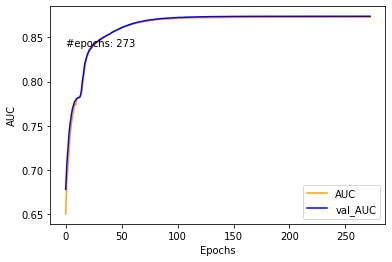

In [31]:
import matplotlib.pyplot as plt

initial_learning_rate = 0.01
_epochs = 5000
decay = initial_learning_rate / epochs

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_auc', patience=30, restore_best_weights=True, mode='max')
checkpoint_cb = keras.callbacks.ModelCheckpoint('flu_shot_model.h5', save_best_only=True)

# fit model_seasonal
history = model.fit(training_features, 
                    training_labels, epochs=_epochs, 
                    validation_data=(validation_features,validation_labels), 
                    verbose=0, 
                    callbacks=[keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=0), checkpoint_cb, early_stopping_cb])

epoch_max = len(history.history['loss'])

plt.plot(history.history['auc'], label='AUC', color='orange')
plt.plot(history.history['val_auc'], label='val_AUC', color='b')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.text(0,0.84, '#epochs: '+ str(epoch_max))
plt.legend()

plt.show()

In [37]:
epoch_max = len(history.history['loss'])
history.history['val_auc'][epoch_max-1]

0.8740694522857666

In [22]:
for layer in model.layers:
  print(layer.name)
  print('Weights')
  print("Shape: ",layer.get_weights()[0].shape,'\n',layer.get_weights()[0])
  print("Bias")
  print("Shape: ",layer.get_weights()[1].shape,'\n',layer.get_weights()[1],'\n')

input_layer
Weights
Shape:  (74, 74) 
 [[ 0.12865412  0.1608587   0.02271824 ... -0.10616404 -0.11005491
  -0.03698011]
 [-0.18977022  0.15062267 -0.15255482 ...  0.19976531  0.15196377
  -0.06537281]
 [-0.17578487 -0.01263276 -0.10047649 ... -0.03396455 -0.06996474
  -0.15951358]
 ...
 [ 0.20414205 -0.02993233 -0.16778158 ...  0.18122017 -0.04482783
   0.15463524]
 [ 0.20033805 -0.11990345 -0.12406032 ...  0.05435777  0.13721575
   0.07521991]
 [-0.00833219 -0.10927476 -0.07778716 ...  0.1287376   0.02843967
  -0.205494  ]]
Bias
Shape:  (74,) 
 [ 0.01740709  0.02292157  0.00749754  0.01797965  0.00512982  0.01242208
  0.0226009   0.000605    0.00981235  0.01109591 -0.00058162  0.00571608
  0.02131821  0.02158077  0.02266462  0.00167143  0.00299157  0.006777
 -0.01225117  0.02076925  0.03386704  0.01709303  0.02989963 -0.0019579
  0.02783903 -0.00685677  0.05666653  0.02643719 -0.01007848  0.01339241
  0.00413643  0.02039468  0.0384562   0.02567988 -0.03056995  0.00386518
 -0.00010566 

## PREDICT

In [38]:
from datetime import datetime

def competitionOutput(filenameIn, filenameOut,model):
    # prepare competition features
    competition_features = pd.read_csv(filenameIn)
    competition_features_cleaned = preparation_pipeline.transform(competition_features)
    print('competition features cleaned shape: ', competition_features_cleaned.shape)
    competition_prediction = model.predict(competition_features_cleaned)
    
    competition_result = competition_features
    competition_result['h1n1_vaccine'] = competition_prediction[:,0]
    competition_result['seasonal_vaccine'] = competition_prediction[:,1]
    competition_result = competition_result[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']]
    
    #create output csv
    competition_result.to_csv(filenameOut, index=False)
    
    #save models
    filepath='/content/drive/My Drive/FluShotData/'
    print(model.save(filepath))


    return competition_result




try:
    model = keras.models.load_model('flu_shot_model.h5')
    competition_output = competitionOutput('/content/drive/My Drive/FluShotData/test_set_features.csv', '/content/drive/My Drive/FluShotData/FluShot_result.csv', model)
except NameError:
   # Do nothing.
    print('Errors')



competition features cleaned shape:  (26708, 74)
INFO:tensorflow:Assets written to: /content/drive/My Drive/FluShotData/assets
None


In [39]:
competition_output.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.179562,0.304479
1,26708,0.030825,0.052287
2,26709,0.196100,0.713884
3,26710,0.499302,0.889144
4,26711,0.477022,0.463042
